In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from nba_api.stats.static import players
from nba_api.stats.endpoints import commonplayerinfo, cumestatsplayer
from nba_api.stats.endpoints import playergamelog

In [ ]:
# read player names by command line
lst = ["Jamal Murray", "Nikola Jokic", "Kentavious Caldwell", "Paul George", "Mason Plumlee"]
lg = "00"

In [ ]:
plyrs = players.get_players()

# Player Search
* Can find `player_id` by Full Name
* DataBase of Player names can be quirky, maybe a regex?
* TODO:: Review Docstring for method to determine unexpected behavior (0 matches/multiple matches)

In [ ]:
plyr_names = map(lambda y: y["full_name"], filter(lambda x: x['is_active'] == True, plyrs))
plyr_names = list(plyr_names)
r = {nm : players.find_players_by_full_name(nm)[0]["id"] for nm in lst}
dat = {nm : playergamelog.PlayerGameLog(player_id=r[nm], season="2023").get_data_frames()[0] for nm in r.keys()}

Each item in this dictionary is a `{name : pandas DataFrame}` pair. The DataFrame `info()` output is below

# DataFrame Housekeeping
* Current
    * `WL` column is "L" or "W", object dtype. Map to 1:W, 0:L
    * `Matchup` contains opponent detail as well as home/away. Should attempt two RegEx matches in order to determine Home/Away status and then strip the opponent data. Return both pieces of info as a tuple, add each item in tuple to DataFrame. Once a stable method is in place, `git commit` then see how ChatGPT does
    * `GAME_DATE` might convert right into a DateTime object
    * `SEASON_ID` and `Game_ID` are nominal-numeric, unsure of what they could be used for... consult docs? TODO:: find docs


* Future
    * Video Available seems cool, will have to call `help` on library function that retrieves DataFrame

In [ ]:
import re

def map_matchup(x):
    homeMatch = re.compile("(\w+) vs. (\w+)")
    awayMatch = re.compile("(\w+) @ (\w+)")
    if homeMatch.match(x):
        return ("Home", homeMatch.match(x).groups()[-1])
    elif awayMatch.match(x):
        return ("Away", awayMatch.match(x).groups()[-1])
    else:
        return None

In [ ]:
def map_wl(x):
    if x == "W":
        return 1
    elif x == "L":
        return 0
    else:
        return None

In [ ]:
def map_gamedate(x):
    return pd.to_datetime(x)

In [ ]:
def clean_df(df):
    if "MATCHUP" in df.columns:
        res = df.MATCHUP.map(map_matchup)
        df["HomeAway"] = res.map(lambda x: x[0])
        df["Opponent"] = res.map(lambda x: x[1])
        df.drop(columns=["MATCHUP"], inplace=True, axis=1)
    elif "HomeAway" in df.columns and "Opponent" in df.columns:
        if "MATCHUP" in df.columns:
            df.drop(columns=["MATCHUP"], inplace=True, axis=1)
    else:
        print("Issue with DataFrame:\nMissing MATCHUP column\nNeed to re-query API")
    # df["WL"] = df["WL"].map(map_wl)
    df["GameDate"] = df["GAME_DATE"].map(map_gamedate)
    return df

In [ ]:
d = dict(
            zip(dat.keys(), list( map(clean_df, dat.values()) ))
        )

In [ ]:
d.keys()

In [ ]:
from dash import Dash, html, dcc, callback, Output, Input, State
import plotly.express as px

In [ ]:
stats = ['MIN', 'FGM',
       'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'PLUS_MINUS']

In [ ]:
df = d["Paul George"]

app = Dash("Player Viz")

app.layout = html.Div([
    html.Div([dcc.Dropdown(id="stat", options=stats, value="PTS")], id="stat_controls"),
    html.Div([dcc.Dropdown(id="player", options=[{"label": nm, "value": nm} for nm in lst], value=lst[0])], id="plyr_controls"),
    html.Button("Add Stat", id="stat_add"),
    html.Button("Remove Stat", id="stat_remove"),
    # html.Button("Add Player", id="player_add"),
    # html.Button("Remove Player", id="player_remove"),
    dcc.Graph(figure = {}, id="controls-and-graph")
])

@callback(
        Output("stat_controls", "children"),
        Input("stat_add", "n_clicks"),
        Input("stat_remove", "n_clicks"),
        State("stat_controls", "children"),
        allow_duplicate=True
)
def add_stats(y_clicks, n_clicks, curr_children):
    if y_clicks:
        return dcc.Dropdown(id="stat", options=stats, value=stats[0])
    elif n_clicks:
        if curr_children:
            curr_children.pop()
            return curr_children
        else:
            return []

    
@callback(
    Output(component_id="controls-and-graph", component_property="figure"),
    Input(component_id="controls-and-graph", component_property="figure"),
    Input(component_id="player", component_property="value"),
    Input(component_id="stat", component_property="value")
)
def update_graph(fig, player, stat):
    if fig:
        fig['data'].append(px.line(x=d[player].GameDate, y=d[player][stat], title=f"{player} {stat} by Game"))
    else:
        df = d[player]
        fig = px.scatter(df, 
                        x="GameDate",
                        y=stat, 
                        color="WL", 
                        color_discrete_sequence=["red", "green"],
                        #  trendline="mean",
                        #  color_discrete_map={0:"red", 1:"green"}, 
                        title=f"{player} {stat} by Game"
                        )
    return fig

In [ ]:
app.run(debug=True)

In [ ]:
d["Paul George"].WL.head()


In [ ]:
import plotly as plt

In [ ]:
s = plt.graph_objects.Scatter(x = d["Paul George"].GameDate.unique(), y=d["Paul George"].PTS, fill="none", connectgaps=False, customdata=d["Paul George"])
# fig.add_hline(d["Paul George"].PTS.mean())
fig = plt.graph_objects.Figure(data=[s])


fig.show()

In [ ]:
# Build a list of players on the 2024 Cleveland Cavaliers and Miami Heat

curr = ["Jarrett Allen", "Darius Garland", "Terry Rozier", "Isaac Okoro", "Caris LeVert", "Georges Niang", "Jimmy Butler", "Marcus Morris Sr.", "Nikola Jovic", "Sam Merrill", "Donovan Mitchell", "Damian Jones", "Craig Porter Jr.",
 "Duncan Robinson", "Bam Adebayo", "Haywood Highsmith", "Jaime Jaquez Jr.", "Caleb Martin", "Patty Mills", "Thomas Bryant" ]

In [ ]:
r = {nm : players.find_players_by_full_name(nm) for nm in curr}
r


In [ ]:
r["Jarrett Allen"]

In [ ]:
def try_Data(nm):
    try:
        return playergamelog.PlayerGameLog(player_id=r[nm][0]["id"], season="2023").get_data_frames()[0]
    except:
        return None

In [ ]:
newdat = {nm : try_Data(nm) for nm in r.keys()}

In [ ]:
d = dict(
            zip(newdat.keys(), list( map(clean_df, newdat.values()) ))
        )

In [ ]:
ja = d["Jarrett Allen"]
jb = d["Jimmy Butler"]
tr = d["Terry Rozier"]
dg = d["Darius Garland"]

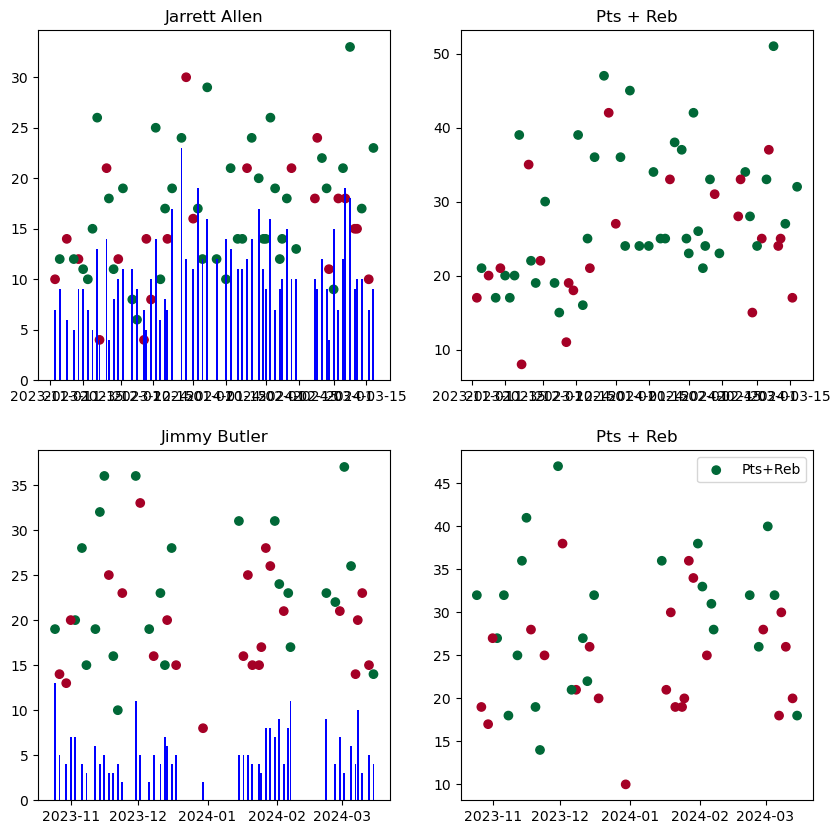

In [76]:
# fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# axes[0].scatter(ja.GameDate, ja.PTS, label="Jarrett Allen", c=ja["WL"].map(map_wl))
# axes[1].scatter(jb.GameDate, jb.PTS, label="Jimmy Butler", c=jb["WL"].map(map_wl))

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Scatter plot for ja dataframe on axes[0]
scatter_ja = axes[0][0].scatter(ja.GameDate, ja.PTS, label="Pts", c=ja["WL"].map(map_wl), cmap="RdYlGn")
axes[0][0].bar(ja.GameDate, ja.REB, label="Reb", color="blue")
axes[0][0].set_title("Jarrett Allen")
# plt.colorbar(scatter_ja)

axes[1][0].set_title("Jimmy Butler")

# Scatter plot for jb dataframe on axes[1]
scatter_jb = axes[1][0].scatter(jb.GameDate, jb.PTS, label="Pts", c=jb["WL"].map(map_wl), cmap="RdYlGn")
axes[1][0].bar(jb.GameDate, jb.REB, label="Reb", color="blue")
# plt.colorbar(scatter_jb)


axes[0][1].scatter(ja.GameDate, (ja.PTS+ja.REB), label="Pts+Reb", c=ja["WL"].map(map_wl), cmap="RdYlGn")
axes[0][1].set_title("Pts + Reb")

axes[1][1].scatter(jb.GameDate, (jb.PTS+jb.REB), label="Pts+Reb", c=jb["WL"].map(map_wl), cmap="RdYlGn")
axes[1][1].set_title("Pts + Reb")

plt.legend()
plt.show()

# Some ungodly shit ig

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF

In [ ]:
denCDF = [ECDF(dat[i].PTS) for i in range (3)]

In [ ]:
from statsmodels.distributions.copula.api import CopulaDistribution, GumbelCopula

In [ ]:
jtden = CopulaDistribution(copula=GumbelCopula(), marginals=denCDF)

In [ ]:
jtden.pdf([25,25,25])